# Hindcast evaluation of SEAS5 over the tropical Pacific

In [13]:
import os, glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from hyblim.utils import metric, enso


## Load data

In [2]:
def get_staged_exp(datadir, pattern):
    """Get files matching the pattern in the datadir.

    Args:
    datadir: str
        Directory where the hindcast files are stored.
    pattern: str
        Pattern to match the hindcast files. 
        e.g. 'ifis_ens_0_t2m_*' will match all files starting with 'ifis_ens_0_t2m_'.
    
    Returns:
    ds: xarray.Dataset
        Concatenated dataset with init_time as the new dimension
    """
    full_pattern = os.path.join(datadir, pattern)
    # Find all files matching the pattern
    files = glob.glob(full_pattern)
    # Extract dates from filenames and convert to datetime
    init_dates = [pd.to_datetime(file.split('_')[-1][:8]) for file in files]

    ds_list = []
    for f in files:
        tmp = xr.open_dataset(f)
        # Replace time dimension with lag dimension i.e. 0 to len(time) 
        tmp = tmp.rename({'time': 'lag'})
        tmp['lag'] = np.arange(1, len(tmp.lag)+1)
        ds_list.append(tmp)

    return xr.concat(ds_list, dim=pd.Index(init_dates, name='init_time')).sortby('init_time')

stagedir = "/ec/res4/scratch/ecm1922/cepdiag/seas/stage/"
# Target
era5_target = get_staged_exp(stagedir, 'seas5_era5_0_sst_*')
# Forecast
seas5_ensemble = []
for member in range(0,10):
    seas5_ensemble.append(get_staged_exp(stagedir, f'seas5_ens_{member}_sst_*'))

seas5_ensemble = xr.concat(seas5_ensemble, dim=pd.Index(range(0,10), name='member'))
seas5_ensemble = seas5_ensemble.sel(init_time=era5_target.init_time)

## Preprocess data

In [3]:
# Select Tropial Pacific region 
def select_tropics(ds, lsm):
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat', 'init_time': 'time'})
    ds= ds.interp_like(lsm, method='nearest')
    ds = ds.where(lsm!=1, other=np.nan)
    return ds

lsm = xr.open_dataset("../../data/land_sea_mask_common.nc")['lsm']
seas5_ensemble = select_tropics(seas5_ensemble, lsm)
era5_target = select_tropics(era5_target, lsm)

In [4]:
# Compute climatology
climatology = era5_target['sst'].groupby('time.month').mean('time')
era5_anomaly = era5_target['sst'].groupby('time.month') - climatology
era5_target['ssta'] = era5_anomaly

seas5_ensemble_anomaly = seas5_ensemble['sst'].groupby('time.month') - climatology
seas5_ensemble['ssta'] = seas5_ensemble_anomaly


## Compute scores

In [5]:
verification_per_gridpoint, verification_per_time, nino_indices = [], [], []
for lag in seas5_ensemble.lag.values:
    x_target = era5_target.sel(lag=lag)
    x_hindcast = seas5_ensemble.sel(lag=lag)

    print(f"Compute metrics of lag={lag}!", flush=True)
    x_frcst_mean = x_hindcast.mean(dim='member')
    x_frcst_std = x_hindcast.std(dim='member', ddof=1)
    n_members = len(x_hindcast['member'])

    # Compute metrics per gridpoint
    grid_verif = metric.verification_metrics_per_gridpoint(
        x_target, x_frcst_mean, x_frcst_std, n_members=n_members
    )
    grid_verif['lag'] = lag
    verification_per_gridpoint.append(grid_verif)

    # Compute metrics per time
    time_verif = metric.verification_metrics_per_time(
        x_target, x_frcst_mean, x_frcst_std, n_members=n_members
    )
    time_verif['lag'] = lag
    verification_per_time.append(time_verif)

    # Nino indices
    nino_index = {
        'target': enso.get_nino_indices(x_target['ssta']),
        'frcst': enso.get_nino_indices(x_hindcast['ssta']),
        'lag': lag
    }
    nino_indices.append(nino_index)

grid_scores = metric.listofdicts_to_dictofxr(verification_per_gridpoint, dim_key='lag')
time_scores = metric.listofdicts_to_dictofxr(verification_per_time, dim_key='lag')
nino_ids = metric.listofdicts_to_dictofxr(nino_indices, dim_key='lag')


Compute metrics of lag=1!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=2!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=3!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=4!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=5!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=6!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=7!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=8!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=9!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=10!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=11!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=12!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=13!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

## Plot temporal metrics

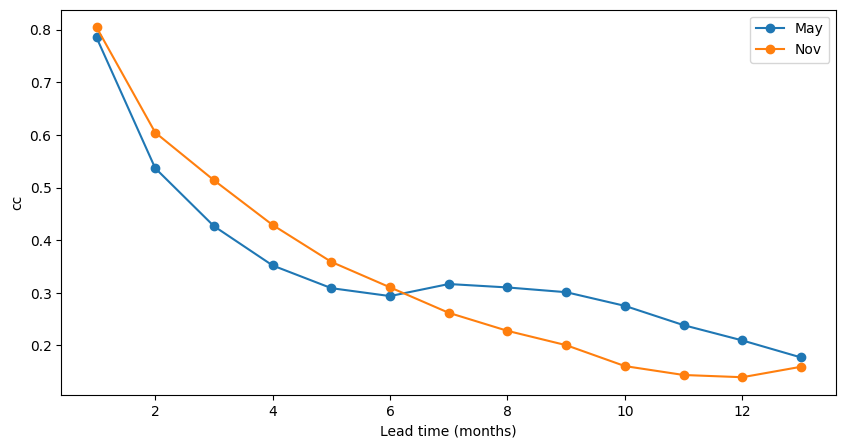

In [6]:
score_key = 'cc'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
score = time_scores[score_key]['ssta'].groupby('time.month').mean('time')
ax.plot(score.lag, score.sel(month=5), marker='o', label='May')
ax.plot(score.lag, score.sel(month=11), marker='o', label='Nov')
ax.set_xlabel('Lead time (months)')
ax.set_ylabel(score_key)
ax.legend()

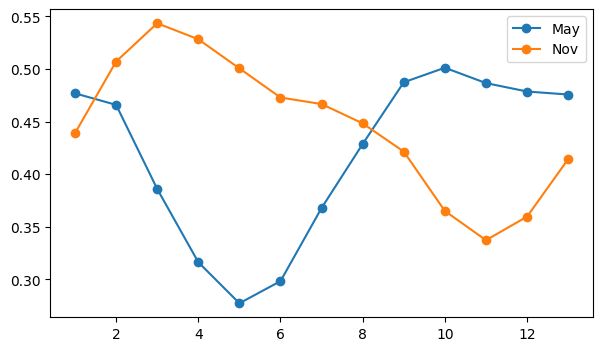

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
skill_spread = time_scores['spread_skill']['ssta'].groupby('time.month').mean('time')
ax.plot(skill_spread.lag, skill_spread.sel(month=5), 'o-', label='May')
ax.plot(skill_spread.lag, skill_spread.sel(month=11), 'o-', label='Nov')
ax.legend()

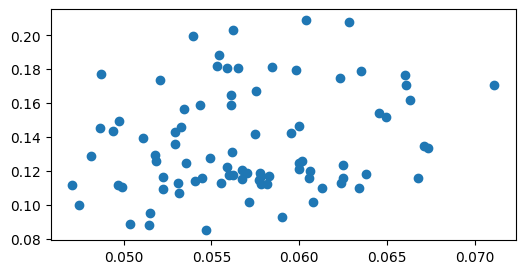

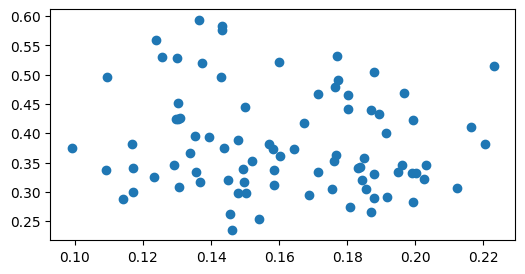

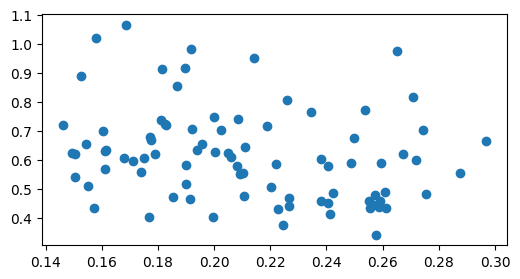

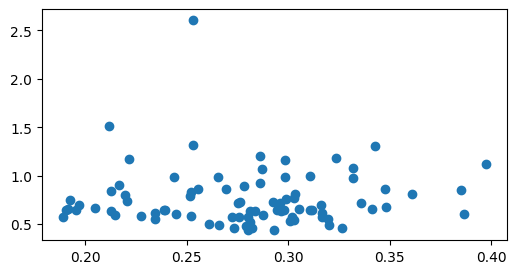

In [8]:
for lag in [1, 3, 6, 12]:
    spread = time_scores['spread']['ssta'].sel(lag=lag)
    skill = time_scores['mse']['ssta'].sel(lag=lag)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.scatter(spread.data, skill.data, label=f"Lag {lag}")


## Nino indices

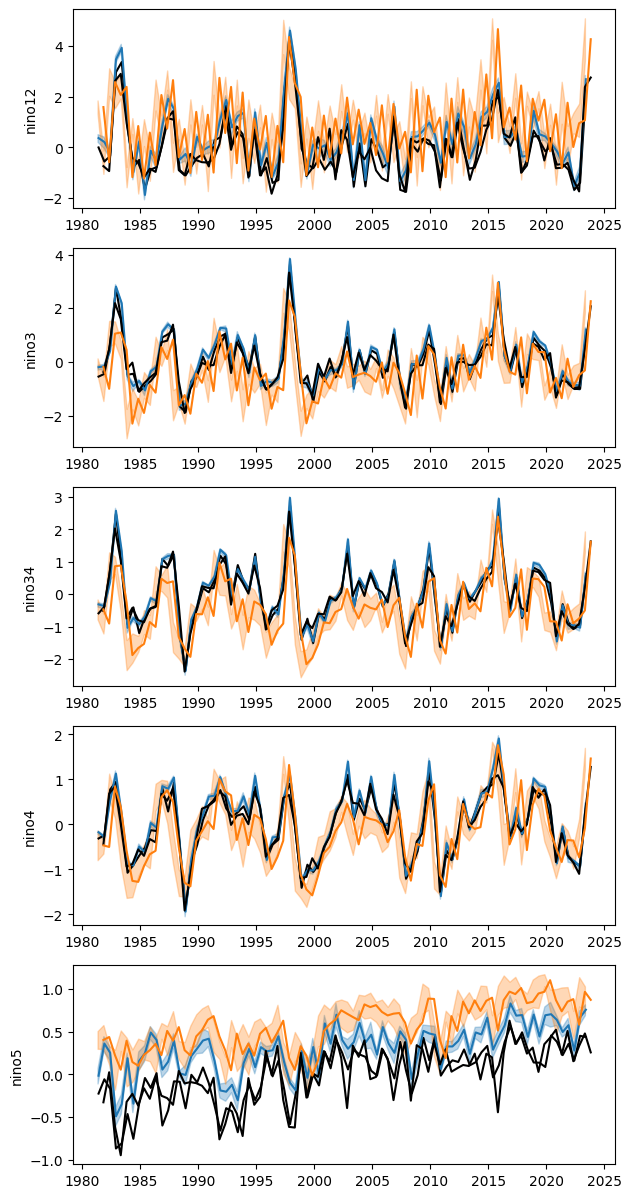

In [9]:
# Plot Nino indices
nrows = len(nino_ids['target'].data_vars)
fig, axs = plt.subplots(nrows, 1, figsize=(7, 3*nrows))

for i, var in enumerate(nino_ids['target'].data_vars):
    ax = axs[i]
    for lag in [1, 6]:
        nino_target = nino_ids['target'][var].sel(lag=lag)
        nino_frcst = nino_ids['frcst'][var].sel(lag=lag)

        dates = np.array(nino_target.time,dtype='datetime64[M]') + np.timedelta64(lag, 'M')
        ax.plot(dates, nino_target, color='k', label='target')
        pl = ax.plot(dates, nino_frcst.mean('member'), label=f'lag={lag}')
        ax.fill_between(nino_frcst.time, nino_frcst.mean('member') - nino_frcst.std('member'),
                        nino_frcst.mean('member') + nino_frcst.std('member'), color=pl[0].get_color(), alpha=0.3)
    ax.set_ylabel(var)


In [12]:
from  import reload
reload(metric)
nino_scores, nino_scores_month = metric.time_series_score(nino_ids['frcst'], nino_ids['target'])

NameError: name 'metric' is not defined

/dev/shm/_tmpdir_.ecm1922.30360490/ipykernel_602256/31114770.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


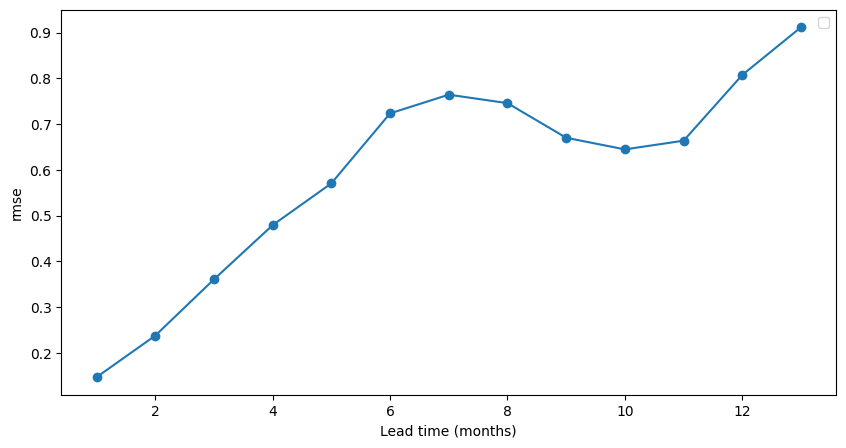

In [69]:
score_key = 'rmse'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
score = nino_scores[score_key]['nino34']
ax.plot(score.lag, score, marker='o')
ax.set_xlabel('Lead time (months)')
ax.set_ylabel(score_key)
ax.legend()

NameError: name 'nino_scores_month' is not defined

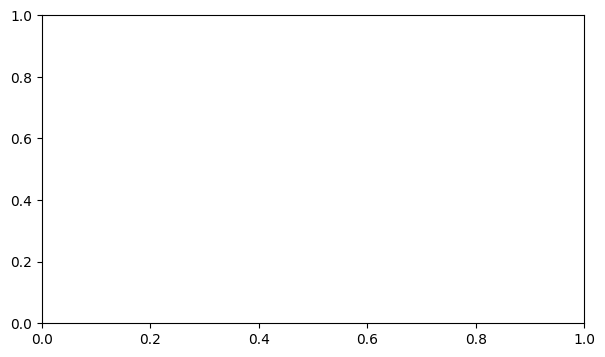

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
skill_spread = nino_scores_month['spread_skill']['nino34']
ax.plot(skill_spread.lag, skill_spread.sel(month=5), 'o-', label='May')
ax.plot(skill_spread.lag, skill_spread.sel(month=11), 'o-', label='Nov')
skill_spread = nino_scores['spread_skill']['nino34']
ax.plot(skill_spread.lag, skill_spread, 'o-', label='All')
ax.legend()
ax.axhline(1.0, color='k', linestyle='--')
ax.set_ylim(0, 1.2)

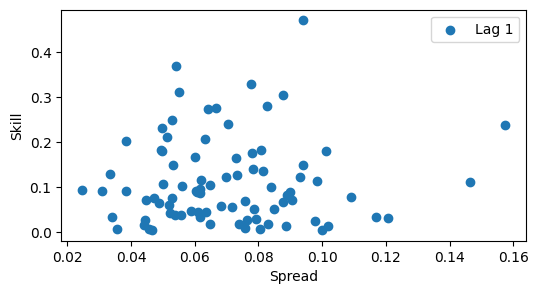

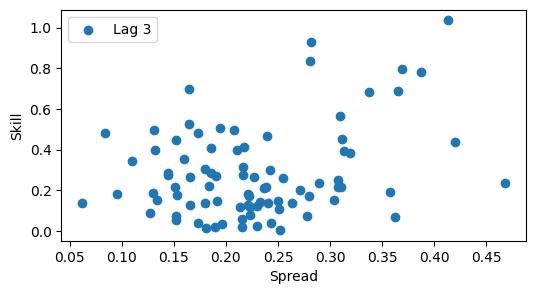

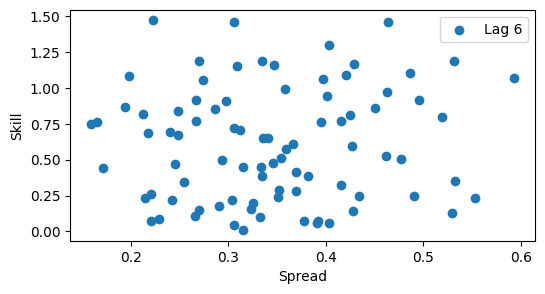

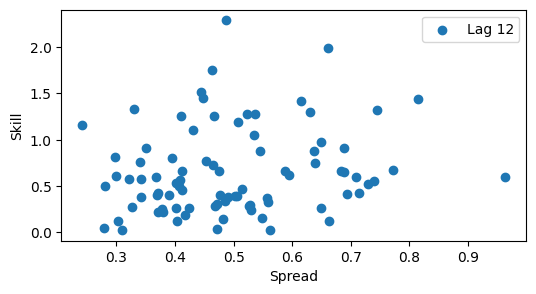

In [63]:
for lag in [1, 3, 6, 12]:
    spread = nino_ids['frcst'].sel(lag=lag).std(dim='member') 
    skill = np.abs(nino_ids['frcst'].sel(lag=lag).mean(dim='member') - nino_ids['target'].sel(lag=lag))

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.scatter(spread['nino34'].values, skill['nino34'].values, label=f"Lag {lag}")
    ax.legend()
    ax.set_xlabel('Spread')
    ax.set_ylabel('Skill')
